### 고양이, 개 분류 - CNN v1

In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-01-18 02:21:08--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   125MB/s    in 0.5s    

2022-01-18 02:21:09 (125 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
!unzip cats_and_dogs_filtered.zip > /dev/null

- 데이터 탐색

In [4]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [5]:
# 파일 이름
import os
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

print(train_cats_fnames[:5])
print(train_dogs_fnames[:5])

['cat.475.jpg', 'cat.782.jpg', 'cat.757.jpg', 'cat.330.jpg', 'cat.672.jpg']
['dog.673.jpg', 'dog.342.jpg', 'dog.278.jpg', 'dog.43.jpg', 'dog.926.jpg']


In [6]:
# 파일 갯수
len(train_cats_fnames), len(train_dogs_fnames)

(1000, 1000)

- 이미지 확인

In [7]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [8]:
fname = os.path.join(train_cats_dir, 'cat.475.jpg')
fname

'cats_and_dogs_filtered/train/cats/cat.475.jpg'

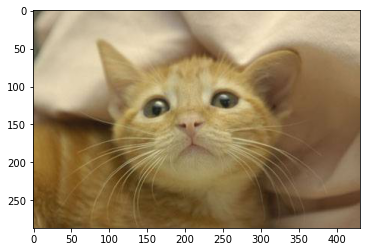

In [9]:
img = Image.open(fname)
plt.imshow(img);

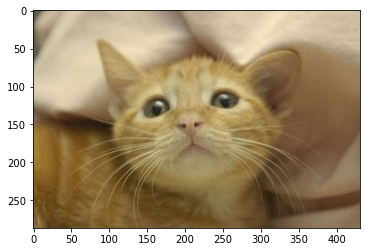

In [10]:
img = cv2.imread(fname)[:,:,::-1]
plt.imshow(img);

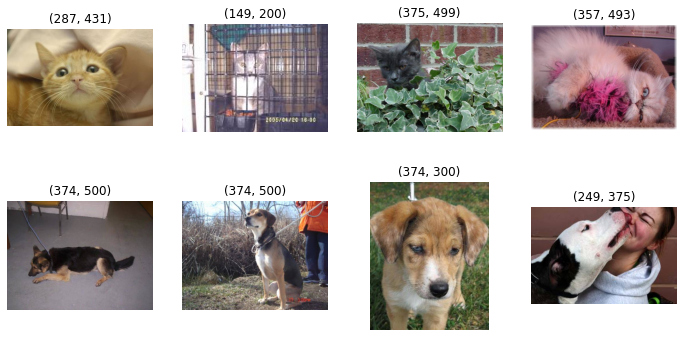

In [11]:
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2,4,i+1)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])

    plt.subplot(2,4,i+5)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])

plt.show()

- 모델 구성

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [13]:
model = Sequential([
    Conv2D(16, kernel_size=(3,3), input_shape=(150,150,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

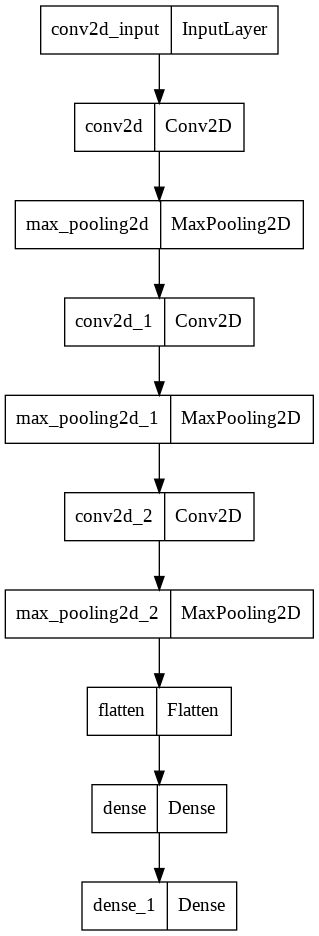

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model)

- 모델 설정

In [15]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-8),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

- 파일에서 이미지 데이터 읽어오는 방법

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [17]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


- callback 정의

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'best-cat-dog-v1.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10)

- 모델 실행

In [ ]:
hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=100,        # 한번의 epoch에서 훈련에 사용할 batch의 갯수
    validation_steps=50,        # 한번의 epoch가 끝났을 때, 테스트에 사용되는 batch의 갯수
    verbose=2,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.61076, saving model to best-cat-dog-v1.h5
100/100 - 62s - loss: 0.7884 - accuracy: 0.5645 - val_loss: 0.6108 - val_accuracy: 0.6820 - 62s/epoch - 623ms/step
Epoch 2/100

Epoch 00002: val_loss improved from 0.61076 to 0.59767, saving model to best-cat-dog-v1.h5
100/100 - 60s - loss: 0.6230 - accuracy: 0.6745 - val_loss: 0.5977 - val_accuracy: 0.7090 - 60s/epoch - 599ms/step
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.59767
100/100 - 59s - loss: 0.5475 - accuracy: 0.7190 - val_loss: 0.6731 - val_accuracy: 0.6390 - 59s/epoch - 586ms/step
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.59767
100/100 - 59s - loss: 0.4793 - accuracy: 0.7745 - val_loss: 0.6097 - val_accuracy: 0.7070 - 59s/epoch - 588ms/step
Epoch 5/100

Epoch 00005: val_loss improved from 0.59767 to 0.58171, saving model to best-cat-dog-v1.h5
100/100 - 58s - loss: 0.3996 - accuracy: 0.8210 - val_loss: 0.5817 - val_accuracy: 0.7200 - 58s/epoch - 

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)

- 테스트 이미지 분류

In [22]:
from google.colab import files

up = files.upload()

Saving cat.jpg to cat.jpg


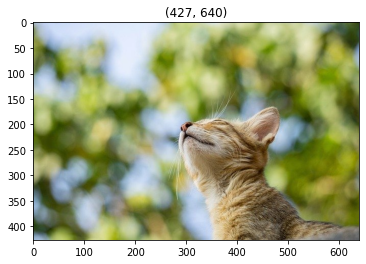

In [23]:
img = cv2.imread('cat.jpg')[:,:,::-1]
plt.imshow(img), plt.title(img.shape[:-1]);

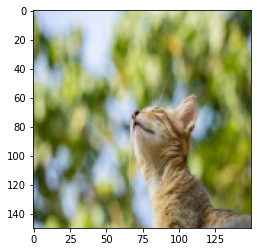

In [25]:
# 150 x 150 size
img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
plt.imshow(img);

In [26]:
best_model.predict(img.reshape(1,150,150,3))

array([[1.]], dtype=float32)

In [27]:
for fname in up.keys():
    img = cv2.imread(fname)[:,:,::-1]
    if sum(img.shape[:-1]) > 300:       # 150 x 150 보다 큰 이미지
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
    else:
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_CUBIC)
    classes = best_model.predict(img.reshape(1,150,150,3))
    print(f"{classes[0,0]:.4f} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")

1.0000 cat.jpg is a dog


- 학습과정 시각화

In [28]:
import numpy as np
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

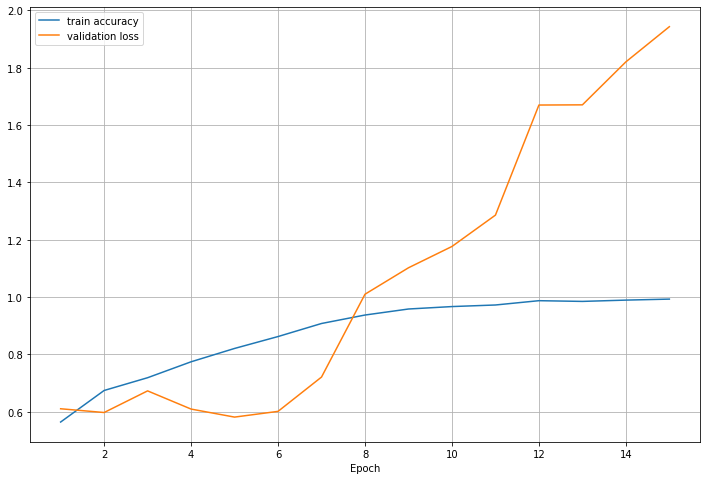

In [29]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()